## Importing Libraries and Setting Up the Environment for ResNet Training

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary libraries
import os, sys

# Add the module path to the sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import necessary libraries
import time
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from utils.evaluation import set_all_seeds
from utils.plotting import plot_training_loss

## Setting Up Training Parameters for ResNet

In this section, we define several settings that will be used for training the ResNet model:

- `RANDOM_SEED`: This is the seed for the random number generator. We set it to ensure that our experiments can be reproduced.
- `BATCH_SIZE`: This is the number of training examples utilized in one iteration. We set it to 256.
- `NUM_EPOCHS`: The number of times the entire training dataset is shown to the network during training. Set to 8 in this case.
- `DEVICE`: This is the device where the tensor computations will be performed. We set it to use the first CUDA device if available, otherwise it falls back to CPU.

In [4]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Preprocessing and Loading the Furniture Dataset

In this section, we perform several preprocessing steps on the furniture dataset and load it into memory:

1. **Define Transformations**: We define transformations for the training and testing datasets. For the training dataset, we resize the images to 120x120, perform a random crop to 110x110, convert the images to PyTorch tensors, and normalize them. For the testing dataset, we perform the same steps, but replace the random crop with a center crop.

2. **Load the Dataset**: We load the dataset from the specified path and apply the training transformations.

3. **Split the Dataset**: We split the dataset into training, validation, and testing sets according to the specified proportions.

4. **Apply Test Transformations**: We apply the testing transformations to the validation and testing datasets.

5. **Create Data Loaders**: We create data loaders for the training, validation, and testing datasets. These will allow us to efficiently iterate over the datasets during training.

6. **Check the Dataset**: We print out the dimensions of an image batch and label batch from the training dataset, as well as the class labels of 10 examples, to ensure everything is working correctly.

In [5]:
set_all_seeds(RANDOM_SEED)

In [6]:
dataPath = '../../Data/Processed_Data/'
train_val_test_split = [0.8, 0.15, 0.05]

### CombinedDataset Class Description

The `CombinedDataset` class is a custom dataset class for loading and managing images, as well as their corresponding style and category labels. This class inherits from the `torch.utils.data.Dataset` and provides methods to handle the dataset effectively. Below is a detailed description of its components and functionalities:

#### `__init__(self, root_dir, transform=None)`
- **Parameters**:
  - `root_dir` (str): The root directory containing the dataset, organized by category and style.
  - `transform` (callable, optional): A function/transform that takes in a PIL image and returns a transformed version.

- **Attributes**:
  - `root_dir`: Stores the root directory path.
  - `transform`: Stores the transform function.
  - `image_paths` (list): Stores the paths of all images.
  - `style_labels` (list): Stores the style labels of all images.
  - `category_labels` (list): Stores the category labels of all images.
  - `category_to_idx` (dict): Maps category names to indices.
  - `style_to_idx` (dict): Maps style names to indices.
  - `idx_to_style` (list): Maps indices to style names.
  - `idx_to_category` (list): Maps indices to category names.

- **Methods**:
  - `self._prepare_dataset()`: Called during initialization to populate `image_paths`, `style_labels`, and `category_labels`.

#### `_prepare_dataset(self)`
- Iterates through the directory structure starting from `root_dir`, and for each category and style, it does the following:
  - Updates `category_to_idx` and `idx_to_category` if a new category is encountered.
  - Updates `style_to_idx` and `idx_to_style` if a new style is encountered.
  - Collects the paths of all images and their corresponding style and category labels.
- **Note**: It only considers files with extensions 'jpg', 'jpeg', or 'png'.

#### `__len__(self)`
- Returns the total number of images in the dataset by returning the length of `image_paths`.

#### `__getitem__(self, idx)`
- **Parameters**:
  - `idx` (int): The index of the item to be fetched.

- **Returns**:
  - A tuple `(image, style_label, category_label)`:
    - `image` (PIL Image): The transformed image.
    - `style_label` (int): The index of the style label corresponding to the image.
    - `category_label` (int): The index of the category label corresponding to the image.

- Opens the image file at the path specified by `image_paths[idx]`, converts it to RGB, applies the transform if provided, and returns the image along with its style and category labels.

In [7]:
class CombinedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.style_labels = []
        self.category_labels = []
        self.category_to_idx = {}
        self.style_to_idx = {}
        self.idx_to_style = []
        self.idx_to_category = []

        self._prepare_dataset()

    def _prepare_dataset(self):
        category_idx = 0
        style_idx = 0
        for category in os.listdir(self.root_dir):
            category_path = os.path.join(self.root_dir, category)
            if not os.path.isdir(category_path):
                continue
            if category not in self.category_to_idx:
                self.category_to_idx[category] = category_idx
                self.idx_to_category.append(category)
                category_idx += 1
            for style in os.listdir(category_path):
                style_path = os.path.join(category_path, style)
                if not os.path.isdir(style_path):
                    continue
                if style not in self.style_to_idx:
                    self.style_to_idx[style] = style_idx
                    self.idx_to_style.append(style)
                    style_idx += 1
                for image_name in os.listdir(style_path):
                    image_path = os.path.join(style_path, image_name)
                    if image_path.endswith(('jpg', 'jpeg', 'png')):
                        self.image_paths.append(image_path)
                        self.style_labels.append(self.style_to_idx[style])
                        self.category_labels.append(self.category_to_idx[category])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        style_label = self.style_labels[idx]
        category_label = self.category_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, style_label, category_label


In [8]:
##########################
### FURNITURE_DATA
##########################


train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),
    torchvision.transforms.RandomCrop((110, 110)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),        
    torchvision.transforms.CenterCrop((110, 110)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

combinedDataset = CombinedDataset(root_dir=dataPath, transform=train_transforms)

# Determine sizes for each split
total_size = len(combinedDataset)
train_size = int(train_val_test_split[0] * total_size)
valid_size = int(train_val_test_split[1] * total_size)
test_size = total_size - train_size - valid_size

# Split the dataset
train_dataset, valid_dataset, test_dataset = random_split(combinedDataset, [train_size, valid_size, test_size])

# Apply test transform to validation and test datasets
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Checking the dataset
for image, style_label, category_label in train_loader:  
    print('Image batch dimensions:', image.shape)
    print('Image style label dimensions:', style_label.shape)
    print('Image category label dimensions:', style_label.shape)
    print('Class style labels of 10 examples:', style_label[:10])
    print('Class category labels of 10 examples:', category_label[:10])
    break

Image batch dimensions: torch.Size([128, 3, 110, 110])
Image style label dimensions: torch.Size([128])
Image category label dimensions: torch.Size([128])
Class style labels of 10 examples: tensor([ 1,  9,  6,  6,  4, 11, 13, 14, 10, 13])
Class category labels of 10 examples: tensor([5, 1, 5, 5, 3, 4, 3, 0, 3, 3])


## Implementing ResNet Architecture in PyTorch

This code block implements the ResNet (Residual Network) architecture in PyTorch. The ResNet architecture is a deep convolutional neural network known for its ability to train very deep networks without the training process being hindered by the vanishing gradient problem.

1. **Convolutional Layers**: The `conv3x3` and `conv1x1` functions define 3x3 and 1x1 convolutional layers, respectively.

2. **BasicBlock Class**: This class defines a basic block in ResNet, which consists of two layers of 3x3 convolutions/batch norm/ReLU.

3. **Bottleneck Class**: This class defines a bottleneck block in ResNet, which is used for deeper networks. It consists of three layers: 1x1 conv/batch norm/ReLU, 3x3 conv/batch norm/ReLU, and 1x1 conv/batch norm. The shortcut connection is also applied here.

4. **ResNet Class**: This class defines the full ResNet architecture. It includes initial convolutional and max pooling layers, four layers of blocks (either basic or bottleneck), and a final fully connected layer for classification. The `_make_layer` function is used to create each of the four layers of blocks.

The ResNet model is initialized with random weights, and the bias terms are set to zero. If `zero_init_residual` is True, the residual branch's weights are initialized to zero to ensure the model starts as a simple identity mapping. This improves model convergence.

In [9]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(torch.nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class Bottleneck(torch.nn.Module):
    
    expansion=4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(torch.nn.Module):

    def __init__(self, block, layers, num_classes, zero_init_residual=False, groups=1,
                 width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                                     bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    torch.nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    torch.nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks,
                    stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

### CombinedModel Class Description

The `CombinedModel` class is a neural network model that performs both category and style classification for images. This model leverages a pre-defined `ResNet` architecture for category classification and a custom convolutional neural network (CNN) for style classification. Below is a detailed description of its components and functionalities:

#### `__init__(self, num_categories, num_styles)`
- **Parameters**:
  - `num_categories` (int): The number of categories to classify.
  - `num_styles` (int): The number of styles to classify.

- **Attributes**:
  - `category_model`: An instance of `ResNet` pre-configured for category classification.
  - `conv1`, `conv2`, `conv3`: Convolutional layers used for the style classification model.
  - `pool`: Max pooling layer to reduce spatial dimensions.
  - `fc1`, `fc2`: Fully connected layers for the style classification model.
  - `_to_linear`: Attribute to store the size of the flattened output after convolutional layers, used to initialize the fully connected layers.

- **Methods**:
  - `self.calculate_conv_output_shape()`: Called during initialization to determine the output size of the convolutional layers, which is then used to define the input size of the fully connected layers.

#### `calculate_conv_output_shape(self)`
- This method calculates the size of the output tensor after passing through the convolutional and pooling layers. This is necessary to properly initialize the fully connected layers later.

- **Procedure**:
  - Creates a dummy tensor with the same dimensions as the input images.
  - Passes this tensor through the convolutional and pooling layers.
  - Computes the number of elements in the resulting tensor and stores it in `self._to_linear`.

#### `forward(self, x)`
- **Parameters**:
  - `x` (torch.Tensor): The input image tensor.

- **Returns**:
  - `category_logits` (torch.Tensor): The raw, unnormalized scores for each category.
  - `x` (torch.Tensor): The raw, unnormalized scores for each style.

- **Procedure**:
  - Passes the input tensor `x` through the `category_model` to obtain `category_logits`.
  - Extracts the predicted category index using `torch.max`.
  - Passes the input tensor `x` through the custom convolutional layers and pooling layers for style classification.
  - Flattens the output tensor from the convolutional layers.
  - One-hot encodes the predicted category and concatenates it with the flattened tensor.
  - Passes the concatenated tensor through the fully connected layers `fc1` and `fc2` to obtain the style logits.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedModel(nn.Module):
    def __init__(self, num_categories, num_styles):
        super(CombinedModel, self).__init__()
        # Category classification model
        self.category_model = ResNet(BasicBlock, layers=[3, 4, 6, 3], num_classes=num_categories)
        
        # Style classification model
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate the size of the flattened output after the convolutional layers
        self._to_linear = None
        self.calculate_conv_output_shape()
        
        # Initialize fully connected layers with the correct input size
        self.fc1 = nn.Linear(self._to_linear + num_categories, 512)
        self.fc2 = nn.Linear(512, num_styles)

    def calculate_conv_output_shape(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 110, 110)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            self._to_linear = x.numel()

    def forward(self, x):
        # Forward pass through category model
        category_logits = self.category_model(x)
        _, predicted_category = torch.max(category_logits, 1)
        
        # Forward pass through style model
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        
        # One-hot encode the predicted category
        predicted_category_one_hot = torch.zeros(x.size(0), category_logits.size(1)).to(x.device)
        predicted_category_one_hot.scatter_(1, predicted_category.unsqueeze(1), 1)
        
        # Concatenate the one-hot encoded category with image features
        x = torch.cat((x, predicted_category_one_hot), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return category_logits, x

### Initializing the Combined Model

This section of the code demonstrates how to initialize an instance of the `CombinedModel` class, specifying the number of categories and styles dynamically based on the dataset.

#### Steps:
1. **Calculate the Number of Categories and Styles**:
   - `num_categories` is determined by the length of the dictionary `combinedDataset.category_to_idx`.
   - `num_styles` is determined by the length of the dictionary `combinedDataset.style_to_idx`.

2. **Initialize the CombinedModel**:
   - An instance of `CombinedModel` is created with `num_categories` and `num_styles` as arguments.
   - The model is moved to the specified device (`DEVICE`), which can be either a GPU or CPU depending on availability.

#### Explanation:
- `num_categories = len(combinedDataset.category_to_idx)`: This line calculates the number of unique categories in the dataset by checking the length of the `category_to_idx` dictionary.
- `num_styles = len(combinedDataset.style_to_idx)`: This line calculates the number of unique styles in the dataset by checking the length of the `style_to_idx` dictionary.
- `combined_model = CombinedModel(num_categories, num_styles).to(DEVICE)`: This line creates an instance of the `CombinedModel` with the computed number of categories and styles, and transfers the model to the specified device (`DEVICE`).

This initialization ensures that the model is configured correctly based on the actual data available in the dataset, making it flexible and dynamic.

In [11]:
# Initialize the combined model
num_categories = len(combinedDataset.category_to_idx)
num_styles = len(combinedDataset.style_to_idx)
combined_model = CombinedModel(num_categories, num_styles).to(DEVICE)

### Function: `compute_combined_accuracy`

The `compute_combined_accuracy` function calculates the accuracy of a model in predicting both categories and styles from a combined dataset. This function evaluates the model's performance on both classification tasks using a given data loader and device.

#### Parameters:
- `model` (nn.Module): The neural network model to be evaluated.
- `data_loader` (DataLoader): The data loader that provides batches of data for evaluation.
- `device` (torch.device): The device (CPU or GPU) on which the computations will be performed.

#### Returns:
- `accuracy_category` (float): The accuracy of the model in predicting categories, expressed as a percentage.
- `accuracy_style` (float): The accuracy of the model in predicting styles, expressed as a percentage.

In [12]:
# Define accuracy computing for combined dataset
def compute_combined_accuracy(model, data_loader, device):
    model.eval()
    correct_category, correct_style = 0, 0
    total = 0
    with torch.no_grad():
        for features, style_labels, category_labels in data_loader:
            features = features.to(device)
            style_labels = style_labels.to(device)
            category_labels = category_labels.to(device)

            category_logits, style_logits = model(features)
            _, predicted_category = torch.max(category_logits, 1)
            _, predicted_style = torch.max(style_logits, 1)

            total += style_labels.size(0)
            correct_category += (predicted_category == category_labels).sum().item()
            correct_style += (predicted_style == style_labels).sum().item()

    accuracy_category = 100 * correct_category / total
    accuracy_style = 100 * correct_style / total
    return accuracy_category, accuracy_style


In [13]:
# Define train_model for combined datasets
def combined_train_model(model, num_epochs, train_loader, valid_loader, test_loader, optimizer, device, logging_interval=50, scheduler=None, scheduler_on='valid_acc', max_norm=1.0):
    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, style_labels, category_labels) in enumerate(train_loader):
            features = features.to(device)
            style_labels = style_labels.to(device)
            category_labels = category_labels.to(device)

            # Forward and back prop
            category_logits, style_logits = model(features)
            category_loss = torch.nn.functional.cross_entropy(category_logits, category_labels)
            style_loss = torch.nn.functional.cross_entropy(style_logits, style_labels)
            loss = category_loss + style_loss
            
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()

            # Logging
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | Batch {batch_idx:04d}/{len(train_loader):04d} | Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc_category, train_acc_style = compute_combined_accuracy(model, train_loader, device=device)
            valid_acc_category, valid_acc_style = compute_combined_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | Train Category: {train_acc_category:.2f}% | Train Style: {train_acc_style:.2f}% | Validation Category: {valid_acc_category:.2f}% | Validation Style: {valid_acc_style:.2f}%')
            train_acc_list.append((train_acc_category, train_acc_style))
            valid_acc_list.append((valid_acc_category, valid_acc_style))

        elapsed = (time.time() - start_time) / 60
        print(f'Time elapsed: {elapsed:.2f} min')

        if scheduler is not None:
            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1][0])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')

    elapsed = (time.time() - start_time) / 60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc_category, test_acc_style = compute_combined_accuracy(model, test_loader, device=device)
    print(f'Test Category Accuracy: {test_acc_category:.2f}% | Test Style Accuracy: {test_acc_style:.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list


In [14]:
# Define plot accuracy for combined dataset
def combined_plot_accuracy(train_acc_list, valid_acc_list, results_dir):
    num_epochs = len(train_acc_list)

    train_acc_category, train_acc_style = zip(*train_acc_list)
    valid_acc_category, valid_acc_style = zip(*valid_acc_list)

    plt.plot(np.arange(1, num_epochs + 1), train_acc_category, label='Training Category')
    plt.plot(np.arange(1, num_epochs + 1), train_acc_style, label='Training Style')
    plt.plot(np.arange(1, num_epochs + 1), valid_acc_category, label='Validation Category')
    plt.plot(np.arange(1, num_epochs + 1), valid_acc_style, label='Validation Style')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)


Epoch: 001/015 | Batch 0000/0564 | Loss: 6.0133
Epoch: 001/015 | Batch 0100/0564 | Loss: 3.4638
Epoch: 001/015 | Batch 0200/0564 | Loss: 2.9969
Epoch: 001/015 | Batch 0300/0564 | Loss: 2.6522
Epoch: 001/015 | Batch 0400/0564 | Loss: 2.6804
Epoch: 001/015 | Batch 0500/0564 | Loss: 2.6585
Epoch: 001/015 | Train Category: 83.32% | Train Style: 36.08% | Validation Category: 82.05% | Validation Style: 34.59%
Time elapsed: 28.30 min
Epoch: 002/015 | Batch 0000/0564 | Loss: 2.4974
Epoch: 002/015 | Batch 0100/0564 | Loss: 2.2539
Epoch: 002/015 | Batch 0200/0564 | Loss: 2.2213
Epoch: 002/015 | Batch 0300/0564 | Loss: 2.3408
Epoch: 002/015 | Batch 0400/0564 | Loss: 2.4418
Epoch: 002/015 | Batch 0500/0564 | Loss: 2.3229
Epoch: 002/015 | Train Category: 85.97% | Train Style: 40.83% | Validation Category: 84.03% | Validation Style: 37.43%
Time elapsed: 56.06 min
Epoch: 003/015 | Batch 0000/0564 | Loss: 2.0126
Epoch: 003/015 | Batch 0100/0564 | Loss: 2.0502
Epoch: 003/015 | Batch 0200/0564 | Loss: 2

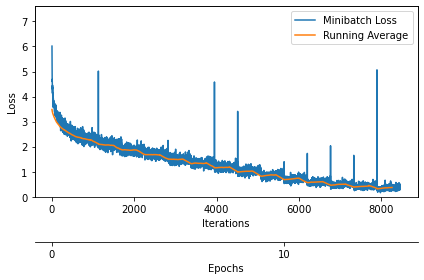

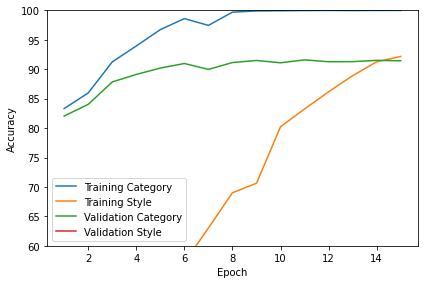

In [15]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

combined_model.apply(initialize_weights)

optimizer = torch.optim.SGD(combined_model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='max', verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = combined_train_model(
    model=combined_model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100
)

plot_training_loss(minibatch_loss_list=minibatch_loss_list, num_epochs=NUM_EPOCHS, iter_per_epoch=len(train_loader), results_dir=None, averaging_iterations=200)
plt.show()

combined_plot_accuracy(train_acc_list=train_acc_list, valid_acc_list=valid_acc_list, results_dir=None)
plt.ylim([60, 100])
plt.show()


## Save the Model

In [16]:
# Save the model and optimizer state
torch.save(combined_model.state_dict(), 'ResNetStyle.pth')
torch.save(optimizer.state_dict(), 'Optimizer_(ResNetStyle).pth')

print("Model and optimizer state saved.")

Model and optimizer state saved.


In [17]:
import pickle

# Save the transformation pipeline
with open('Test_Transform.pkl', 'wb') as f:
    pickle.dump(test_transforms, f)

with open('Train_Transform.pkl', 'wb') as f:
    pickle.dump(train_transforms, f)

print("Transformation pipeline saved.")

Transformation pipeline saved.
